# EEG Data Processing and Analysis Pipeline for Neurofeedback Experiments

### Author: Michael Zhou (mgz2112)

In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from mne.preprocessing import ICA
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
import gc
from joblib import Parallel, delayed
import pickle
import time
from tqdm import tqdm

## 1. Loading and Visualizing EEG Data

Load and analyze EEG data from multiple `.mat` files. Each file contains raw EEG signals collected from various neurofeedback VR flight experiments. 

1. **Load EEG data**: Start by reading EEG data using the `h5py` library, which allows us to access and extract information from MATLAB `.mat` files. The EEG data is stored as a matrix where the rows represent different time points, and the columns represent channels.
2. **Reshape data**: To ensure consistency, we check the shape of the loaded data. If necessary, the data is transposed so that the format aligns with `(channels x time points)`. This reshaping standardizes the data for further analysis.
3. **Visualize data**: For initial exploration, we plot the first 1000 time points of two EEG channels. These plots provide a quick visual check of signal amplitude and variability, helping identify potential noise or artifacts.
4. **Event handling**: Alongside the EEG signals, each file contains event markers that denote specific experimental events (e.g., stimulus presentation or user responses). We extract and decode these events to analyze their types and corresponding time points. A sample of these events is printed to give a sense of the experimental context.
5. **Categorize data**: The files are divided into three experimental conditions: Baseline, Open Loop, and Closed Loop. This categorization allows us to systematically process and analyze data across different experimental phases.

By loading and visualizing EEG data in this manner, we prepare the dataset for subsequent preprocessing and analysis steps, including filtering, epoch extraction, and artifact removal.

In [2]:
# Define file paths for EEG categories

# Baseline (RWEO) files
baseline_files = [
    'S01_B_RWEO_PreOL.mat', 'S01_D_RWEO_PstOL.mat',
    'S01_E_RWEO_PreCL.mat', 'S01_G_RWEO_PstCL.mat'
]

# Open-Loop Calibration (OLoop) files
open_loop_files = ['S01_C_OLoop.mat']

# Closed-Loop Feedback (CLoop and Feedback conditions)
closed_loop_files = ['S01_F_CL_Sil_50_100.mat']

# Define the base directory (where the original data is located)
base_dir = 'Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/' 

# Define the output directory (where the saved variables will be located)
output_dir = 'processed_data/'


--- Baseline Files Analysis ---
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_B_RWEO_PreOL.mat
EEG Data Shape (Time Steps x Channels): (16240, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16240)


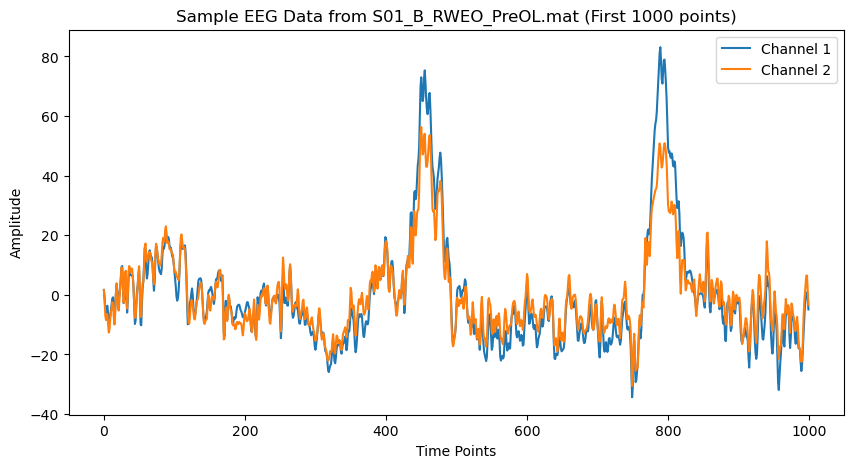

Sample Event Labels from S01_B_RWEO_PreOL.mat:
Type: EBlnk-Int-On, Latency: [330.]
Type: QRS, Latency: [428.]
Type: QRS-B_RWEO_PreOL, Latency: [428.]
Type: EBlnk-On, Latency: [458.]
Type: EBlnk-Off, Latency: [484.]
Type: EBlnk-Int-Off, Latency: [612.]
Type: EBlnk-Int-On, Latency: [671.]
Type: QRS, Latency: [684.]
Type: QRS-B_RWEO_PreOL, Latency: [684.]
Type: EBlnk-On, Latency: [799.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_D_RWEO_PstOL.mat
EEG Data Shape (Time Steps x Channels): (16637, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16637)


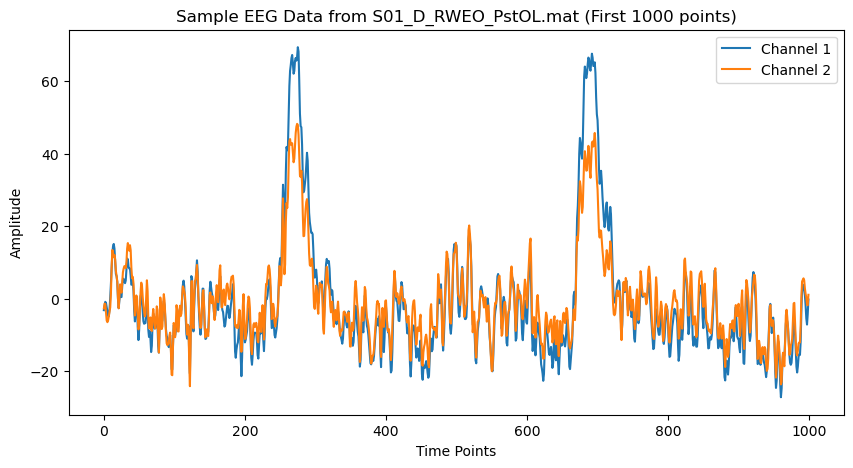

Sample Event Labels from S01_D_RWEO_PstOL.mat:
Type: EBlnk-Int-On, Latency: [154.]
Type: EBlnk-On, Latency: [282.]
Type: EBlnk-Off, Latency: [290.]
Type: QRS, Latency: [377.]
Type: QRS-D_RWEO_PstOL, Latency: [377.]
Type: EBlnk-Int-Off, Latency: [418.]
Type: EBlnk-Int-On, Latency: [567.]
Type: QRS, Latency: [636.]
Type: QRS-D_RWEO_PstOL, Latency: [636.]
Type: EBlnk-On, Latency: [695.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_E_RWEO_PreCL.mat
EEG Data Shape (Time Steps x Channels): (16513, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16513)


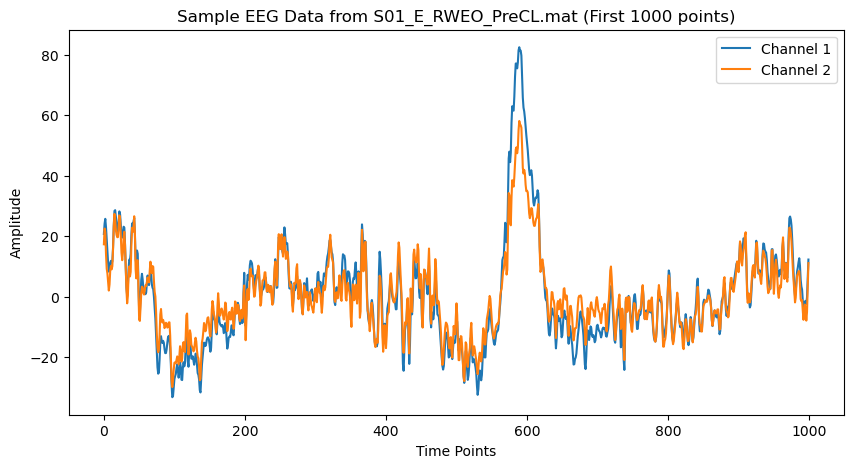

Sample Event Labels from S01_E_RWEO_PreCL.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [1.]
Type: EBlnk-Off, Latency: [84.]
Type: EBlnk-Int-Off, Latency: [212.]
Type: QRS, Latency: [449.]
Type: QRS-E_RWEO_PreCL, Latency: [449.]
Type: EBlnk-Int-On, Latency: [461.]
Type: EBlnk-On, Latency: [589.]
Type: EBlnk-Off, Latency: [628.]
Type: QRS, Latency: [670.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_G_RWEO_PstCL.mat
EEG Data Shape (Time Steps x Channels): (16254, 144)
Transposed EEG Data Shape (Channels x Time): (144, 16254)


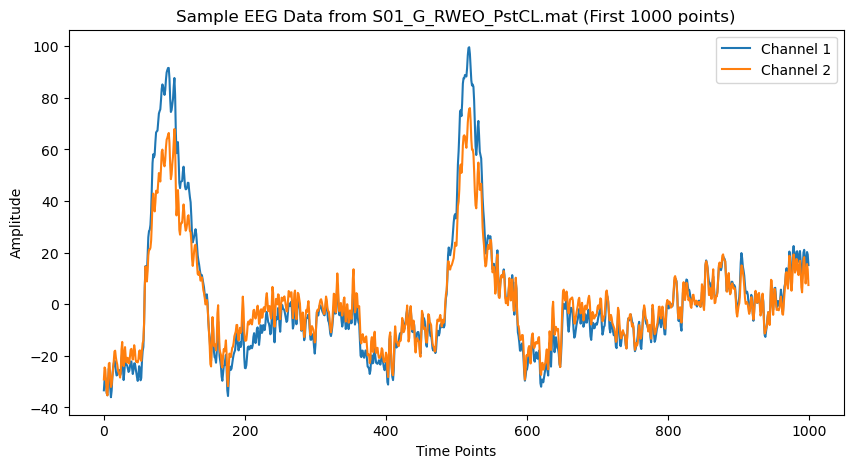

Sample Event Labels from S01_G_RWEO_PstCL.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [82.]
Type: EBlnk-Off, Latency: [125.]
Type: EBlnk-Int-Off, Latency: [253.]
Type: QRS, Latency: [301.]
Type: QRS-G_RWEO_PstCL, Latency: [301.]
Type: EBlnk-Int-On, Latency: [386.]
Type: EBlnk-On, Latency: [514.]
Type: QRS, Latency: [524.]
Type: QRS-G_RWEO_PstCL, Latency: [524.]

--- Open Loop Files Analysis ---
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_C_OLoop.mat
EEG Data Shape (Time Steps x Channels): (139536, 144)
Transposed EEG Data Shape (Channels x Time): (144, 139536)


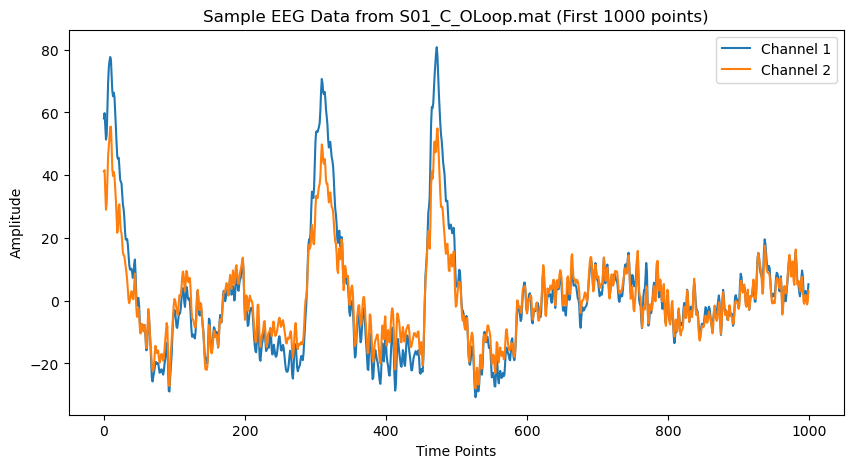

Sample Event Labels from S01_C_OLoop.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [1.]
Type: EBlnk-Off, Latency: [51.]
Type: EBlnk-Int-On, Latency: [174.]
Type: EBlnk-Int-Off, Latency: [179.]
Type: EBlnk-On, Latency: [302.]
Type: EBlnk-Off, Latency: [354.]
Type: EBlnk-Int-On, Latency: [355.]
Type: QRS, Latency: [465.]
Type: QRS-C_OLoop, Latency: [465.]

--- Closed Loop Files Analysis ---
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_F_CL_Sil_50_100.mat
EEG Data Shape (Time Steps x Channels): (441421, 144)
Transposed EEG Data Shape (Channels x Time): (144, 441421)


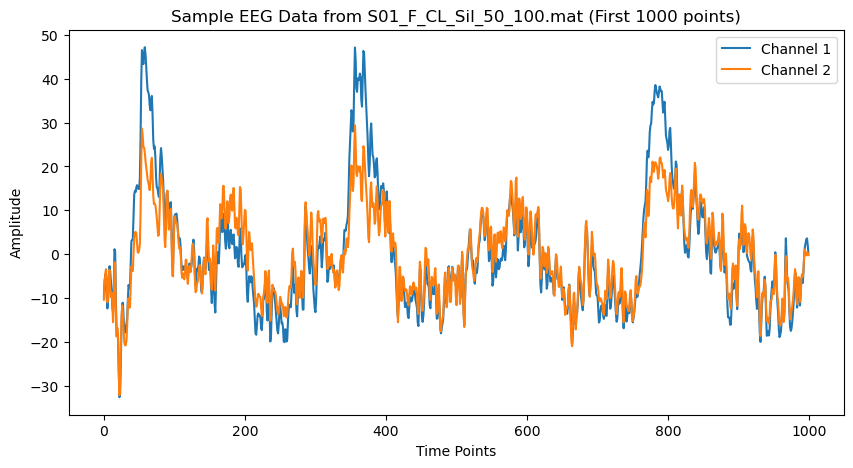

Sample Event Labels from S01_F_CL_Sil_50_100.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [59.]
Type: EBlnk-Off, Latency: [106.]
Type: Art_HBeat_Audio_Onset, Latency: [152.329]
Type: EBlnk-Int-Off, Latency: [234.]
Type: EBlnk-Int-On, Latency: [234.]
Type: EBlnk-On, Latency: [362.]
Type: QRS, Latency: [368.]
Type: QRS-F_CL_Sil_50_100, Latency: [368.]
Type: EBlnk-Off, Latency: [417.]
Loaded file: Faller_et_al_2019_PNAS_EEG_Neurofeedback_VR_Flight/S01_F_CL_Sil_50_100.mat
EEG Data Shape (Time Steps x Channels): (441421, 144)
Transposed EEG Data Shape (Channels x Time): (144, 441421)


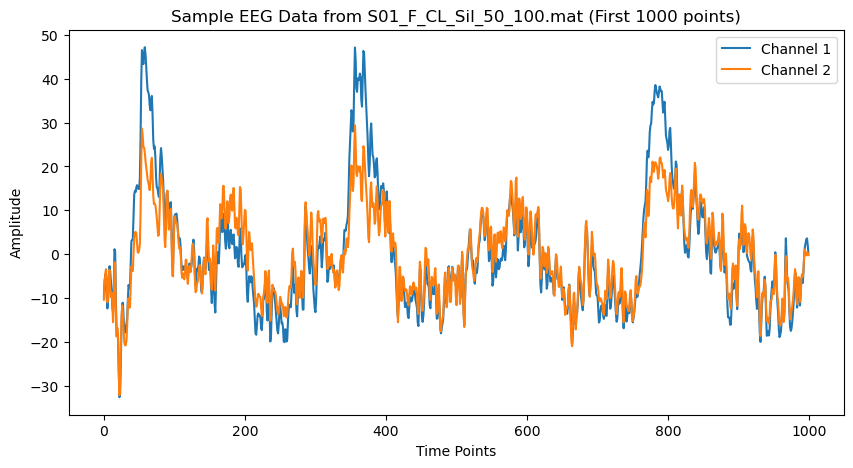

Sample Event Labels from S01_F_CL_Sil_50_100.mat:
Type: EBlnk-Int-On, Latency: [1.]
Type: EBlnk-On, Latency: [59.]
Type: EBlnk-Off, Latency: [106.]
Type: Art_HBeat_Audio_Onset, Latency: [152.329]
Type: EBlnk-Int-Off, Latency: [234.]
Type: EBlnk-Int-On, Latency: [234.]
Type: EBlnk-On, Latency: [362.]
Type: QRS, Latency: [368.]
Type: QRS-F_CL_Sil_50_100, Latency: [368.]
Type: EBlnk-Off, Latency: [417.]


In [5]:
def load_and_analyze_eeg(file_path):
    with h5py.File(file_path, 'r') as f:
        # Access EEG data and display shape
        eeg_data = np.array(f['actualVariable']['EEG_full']['data'])
        print(f"Loaded file: {file_path}")
        print(f"EEG Data Shape (Time Steps x Channels): {eeg_data.shape}")
        
        # Ensure data is correctly shaped as (channels, time_steps)
        if eeg_data.shape[1] == 144:  # If shape is (time_steps, channels)
            eeg_data = eeg_data.T  # Transpose to (channels, time_steps)
        
        print(f"Transposed EEG Data Shape (Channels x Time): {eeg_data.shape}")
        
        # Plot first two channels for a visual check
        plt.figure(figsize=(10, 5))
        plt.plot(eeg_data[0, :1000], label='Channel 1')
        plt.plot(eeg_data[1, :1000], label='Channel 2')
        plt.title(f"Sample EEG Data from {os.path.basename(file_path)} (First 1000 points)")
        plt.xlabel("Time Points")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

        del eeg_data  # Free memory after processing
        gc.collect()
        
        # Correct event markers handling
        events = f['actualVariable']['EEG_full']['event']
        event_labels = []
        
        for i in range(len(events['type'])):
            # Dereference 'type' and 'latency' using h5py
            event_type_ref = events['type'][i][0]
            event_latency_ref = events['latency'][i][0]
            
            # Read the referenced data
            event_type = ''.join(chr(x) for x in f[event_type_ref][:].flatten())
            event_latency = f[event_latency_ref][()][0]
            event_labels.append((event_type, event_latency))
        
        print(f"Sample Event Labels from {os.path.basename(file_path)}:")
        for event in event_labels[:10]:  # Display first 10 event labels
            print(f"Type: {event[0]}, Latency: {event[1]}")

# Run analysis on each category
for category, file_list in [('Baseline', baseline_files), 
                            ('Open Loop', open_loop_files), 
                            ('Closed Loop', closed_loop_files)]:
    print(f"\n--- {category} Files Analysis ---")
    for file_name in file_list:
        full_path = os.path.join(base_dir, file_name)
        load_and_analyze_eeg(full_path)

## 2. Preprocessing and Analyzing EEG Data: Filtering, Epoch Extraction, and Artifact Removal

We now perform preprocessing on the data below. The pipeline consists of the following steps:
1. **Filter data**:
   - A Butterworth filter is implemented to perform band-pass filtering, allowing only frequencies within a specific range to pass (1-40 Hz). This step helps remove noise and focus on relevant brain activity signals.
   - A high-pass filter is also applied when needed to meet the requirements for Independent Component Analysis (ICA).
2. **Reshape and preprocess data**:
   - Raw EEG data is loaded from `.mat` files using `h5py` and reshaped to ensure consistency in format `(channels x time points)`.
   - Preprocessing steps like NaN and infinite value handling are performed to prepare the data for further analysis.
3. **Extract epochs**:
   - The EEG data is segmented into epochs around specific event markers, defined by experimental conditions. Each epoch represents brain activity surrounding a particular event, allowing for more targeted analysis.
4. **Remove artifacts with ICA**:
   - Independent Component Analysis (ICA) is used to identify and remove artifacts, such as eye movements or muscle activity, from the EEG signals.
   - High-pass filtered epochs are fed into the ICA model to ensure accurate component separation.
5. **Time-Frequency Analysis**:
   - A time-frequency representation of the EEG data is computed using Morlet wavelet transforms. This provides insights into the power of different frequency bands over time, helping to capture dynamic changes in brain activity.
6. **Batch Processing and Memory Optimization**:
   - To handle large datasets efficiently, EEG data is processed in smaller batches. This reduces memory usage and prevents kernel crashes.
   - Garbage collection is used to free up memory after processing each batch.

In [3]:
# IMPORTANT: Switch `rerun` to `False` if you want to load the data (setting `rerun` to `True` runs the cell FOR 10-20 MINS!!)
rerun = False

In [ ]:
import os
import numpy as np
import h5py
from scipy.signal import butter, filtfilt
from mne.preprocessing import ICA
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from joblib import Parallel, delayed
import gc
import time

# Define Butterworth band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    if highcut is None:
        low = lowcut / nyquist
        b, a = butter(order, low, btype='high')
    else:
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=1)

# Load and preprocess EEG data
def load_and_preprocess_eeg(file_path, lowcut=1.0, highcut=40, fs=250, max_retries=5, retry_delay=10):
    retries = 0
    while retries < max_retries:
        try:
            with h5py.File(file_path, 'r') as f:
                eeg_data = np.array(f['actualVariable']['EEG_full']['data'])
                if eeg_data.shape[1] == 144:
                    eeg_data = eeg_data.T

                filtered_data = bandpass_filter(eeg_data, lowcut, highcut, fs)
                filtered_data = np.nan_to_num(filtered_data)
                print(f"Preprocessed EEG Data Shape: {filtered_data.shape}")
                
                # Extract events
                events = f['actualVariable']['EEG_full']['event']
                event_labels = []
                for i in range(len(events['type'])):
                    event_type_ref = events['type'][i][0]
                    event_latency_ref = events['latency'][i][0]
                    event_type = ''.join(chr(x) for x in f[event_type_ref][:].flatten())
                    event_latency = f[event_latency_ref][()][0]
                    event_labels.append((event_type, event_latency))
                
                return filtered_data, event_labels
        except TimeoutError as e:
            retries += 1
            print(f"TimeoutError: {e}. Retrying ({retries}/{max_retries})...")
            time.sleep(retry_delay)
    raise TimeoutError(f"Failed to load file {file_path} after {max_retries} attempts.")

# Extract epochs around events
def epoch_eeg_data(eeg_data, event_labels, batch_start, batch_end, epoch_start=-0.2, epoch_end=0.8, fs=250):
    epochs = []
    labels = []
    for etype, elatency in event_labels:
        elatency_relative = elatency - batch_start
        start = int((elatency_relative + epoch_start * fs))
        end = int((elatency_relative + epoch_end * fs))
        if start > 0 and end < eeg_data.shape[1]:
            epochs.append(eeg_data[:, start:end])
            labels.append(etype)
    
    epochs = np.array(epochs)
    print(f"Extracted {len(epochs)} epochs for batch range ({batch_start}, {batch_end})")
    return epochs, labels

# Independent Component Analysis (ICA) for artifact removal
def apply_ica(epochs, fs, max_components=10, max_iter=300):
    info = create_info(ch_names=[f'EEG {i+1}' for i in range(epochs.shape[1])], sfreq=fs, ch_types='eeg')
    ica = ICA(n_components=max_components, random_state=42, max_iter=max_iter, verbose=False)
    epochs_highpass = bandpass_filter(epochs, lowcut=1.0, highcut=None, fs=fs)
    epochs_array = EpochsArray(epochs_highpass, info)
    ica.fit(epochs_array)
    print(f"Completed ICA.")
    return ica.apply(epochs_array).get_data()

# Time-Frequency Analysis (parallelized)
def time_frequency_analysis(epoch, sfreq=250, freqs=np.logspace(1, 2, 20)):
    n_channels = epoch.shape[0]
    info = create_info(ch_names=[f'EEG {i+1}' for i in range(n_channels)], sfreq=sfreq, ch_types='eeg')
    tfr = tfr_morlet(EpochsArray([epoch], info), freqs, n_cycles=2, return_itc=False)
    return tfr.data

def parallel_time_frequency_analysis(cleaned_epochs, sfreq=250, freqs=np.logspace(1, 2, 20), n_jobs=-1):
    """Perform parallelized time-frequency analysis."""
    power_chunks = Parallel(n_jobs=n_jobs)(
        delayed(time_frequency_analysis)(epoch, sfreq=sfreq, freqs=freqs) 
        for epoch in tqdm(cleaned_epochs, desc="Time-Frequency Analysis", leave=False)
    )
    return np.concatenate(power_chunks, axis=0)

# Save and load functions
def save_variables(output_dir, file_name, batch_num, **variables):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    save_path = os.path.join(output_dir, f"{file_name}_batch_{batch_num}.npz")
    np.savez_compressed(save_path, **variables)
    print(f"Saved variables for {file_name}, batch {batch_num} to {save_path}")


# Process EEG files
def process_eeg_files_in_batches(file_list, base_dir, batch_size=5000, output_dir='processed_data/', start_batch=1):
    for file_name in file_list:
        full_path = os.path.join(base_dir, file_name)
        print(f"Processing file: {file_name}")
        eeg_data, event_labels = load_and_preprocess_eeg(full_path)
        
        for i in tqdm(range(0, eeg_data.shape[1], batch_size), desc="batch", leave=False):
            batch_num = i // batch_size + 1
            
            # Skip batches before the start_batch
            if batch_num < start_batch:
                print(f"Skipping batch {batch_num} (before start_batch {start_batch}).")
                continue
            
            data = load_variables(output_dir, file_name, batch_num)
            if data and 'power' in data:
                print(f"Loaded saved data for batch {batch_num}. Skipping reprocessing.")
                continue
            
            batch_end = min(i + batch_size, eeg_data.shape[1])
            eeg_batch = eeg_data[:, i:batch_end]
            epochs, labels = epoch_eeg_data(eeg_batch, event_labels, i, batch_end)
            if epochs.size == 0:
                print(f"No valid epochs in batch {batch_num}. Skipping...")
                continue
            
            cleaned_epochs = apply_ica(epochs, fs=250)
            power = parallel_time_frequency_analysis(cleaned_epochs)
            save_variables(output_dir, file_name, batch_num, epochs=epochs, cleaned_epochs=cleaned_epochs, power=power)
            del eeg_batch, epochs, cleaned_epochs, power
            gc.collect()

def load_variables(output_dir, file_name, batch_num):
    load_path = os.path.join(output_dir, f"{file_name}_batch_{batch_num}.npz")
    try:
        if os.path.exists(load_path):
            data = np.load(load_path)
            print(f"Loaded variables from {load_path}")
            return data
    except Exception as e:
        print(f"Error loading {load_path}: {e}")
    return None

def load_batch(file_path):
    """Helper function to load a single batch file."""
    try:
        batch_data = np.load(file_path)
        return {key: batch_data[key] for key in batch_data}
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Efficient batch loader for reduced memory usage
def load_all_saved_batches_in_chunks(output_dir, file_list, chunk_size=5, n_jobs=2):
    """Load saved batches in smaller chunks to prevent memory overflow with progress feedback."""
    loaded_data = {}
    all_batch_files = [f for f in os.listdir(output_dir) if f.endswith(".npz")]
    
    for file_name in tqdm(file_list, desc="Loading Files", position=0, leave=True):
        relevant_files = [os.path.join(output_dir, f) for f in all_batch_files if f.startswith(file_name)]
        chunked_files = [relevant_files[i:i + chunk_size] for i in range(0, len(relevant_files), chunk_size)]
        
        loaded_batches = {}
        for chunk in tqdm(chunked_files, desc=f"Chunks for {file_name}", leave=False):
            batch_data = Parallel(n_jobs=n_jobs)(
                delayed(load_batch)(file_path) for file_path in chunk
            )
            for f, data in zip(chunk, batch_data):
                if data is not None:
                    batch_num = int(f.split('_batch_')[1].split('.npz')[0])
                    loaded_batches[batch_num] = data
            del batch_data
            gc.collect()  # Explicitly free up memory after processing each chunk
        loaded_data[file_name] = loaded_batches
    return loaded_data

# Main Execution
if rerun:
    # If rerun=True, process new data
    for category, file_list in tqdm([('Baseline', baseline_files), 
                                     ('Open Loop', open_loop_files), 
                                     ('Closed Loop', closed_loop_files)], desc="Processing Categories", leave=True):
        print(f"\n--- {category} Files Analysis ---")
        process_eeg_files_in_batches(file_list, base_dir, output_dir=output_dir)
else:
    # Load preprocessed data
    for category, file_list in tqdm([('Baseline', baseline_files), 
                                     ('Open Loop', open_loop_files), 
                                     ('Closed Loop', closed_loop_files)], desc="Loading Categories", leave=True):
        print(f"\n--- Loading {category} Files ---")
        loaded_data = load_all_saved_batches_in_chunks(output_dir, file_list, chunk_size=5, n_jobs=-1)
        print(f"Loaded data for {category}: {loaded_data.keys()}")

Loading Categories:   0%|                                 | 0/3 [00:00<?, ?it/s]


--- Loading Baseline Files ---


Loading Files:  50%|███████████████               | 2/4 [00:23<00:23, 11.60s/it]
Chunks for S01_E_RWEO_PreCL.mat: 0it [00:00, ?it/s]
                                                   
Chunks for S01_G_RWEO_PstCL.mat: 0it [00:00, ?it/s]
Loading Categories:  33%|████████▎                | 1/3 [00:24<00:48, 24.00s/it]

Loaded data for Baseline: dict_keys(['S01_B_RWEO_PreOL.mat', 'S01_D_RWEO_PstOL.mat', 'S01_E_RWEO_PreCL.mat', 'S01_G_RWEO_PstCL.mat'])

--- Loading Open Loop Files ---


Chunks for S01_C_OLoop.mat:   0%|                         | 0/6 [00:00<?, ?it/s]